# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 34.4 s, sys: 3.37 s, total: 37.8 s
Wall time: 37.8 s


In [5]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

In [6]:
years = X_train.year.unique().tolist()
years

[2019, 2022]

In [7]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Move to feature extraction notebook

In [8]:
columns = ['ctx1', 'ctx2', 'ctx3', 'ctx4']
combination = [columns[:i] for i in range(2,len(columns)+1)]

In [9]:
combination

[['ctx1', 'ctx2'], ['ctx1', 'ctx2', 'ctx3'], ['ctx1', 'ctx2', 'ctx3', 'ctx4']]

In [10]:

for comb in combination:
    suffix = '_'.join(comb)
    print(suffix)
    X_train[f'{suffix}_mean'] = X_train[comb].mean(axis=1)
    X_train[f'{suffix}_std'] = X_train[comb].std(axis=1)
    
    X_val[f'{suffix}_mean'] = X_val[comb].mean(axis=1)
    X_val[f'{suffix}_std'] = X_val[comb].std(axis=1)
    
    X_test[f'{suffix}_mean'] = X_test[comb].mean(axis=1)
    X_test[f'{suffix}_std'] = X_test[comb].std(axis=1)
    

ctx1_ctx2
ctx1_ctx2_ctx3
ctx1_ctx2_ctx3_ctx4


# Run pipeline

In [11]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [12]:
columns = X_train.columns[['VALOR' not in i for i in X_train.columns]].to_list()

In [13]:
%%time 

correlations = np.abs(
    X_train[columns].corr(method='pearson').ctx0
).sort_values(ascending=False)

correlations.to_dict()

CPU times: user 6.75 s, sys: 171 ms, total: 6.92 s
Wall time: 6.92 s


{'ctx0': 1.0,
 'ctx1': 0.922782456240714,
 'ctx1_ctx2_mean': 0.8885207453250363,
 'ctx1_ctx2_ctx3_mean': 0.8555430769022581,
 'ctx1_ctx2_ctx3_ctx4_mean': 0.8239822725983219,
 'ctx2': 0.819636295322785,
 'ctx3': 0.7269660619171394,
 'ctx4': 0.6433542864387456,
 'ctx1_ctx2_ctx3_ctx4_std': 0.1788328563180239,
 'ctx1_ctx2_ctx3_std': 0.1624569609205879,
 'ctx1_ctx2_std': 0.13614849127354808,
 'station_id': 0.058572666456470864,
 'month': 0.04797209212986377,
 'dayofyear': 0.04658815108186215,
 'festius': 0.026205363407866854,
 'festius_sun': 0.02428332213799446,
 'hour': 0.02221610656684412,
 'weekend': 0.020687138715983638,
 'festius_sun_sat': 0.020408291886535937,
 'dayofweek': 0.01682990398446328,
 'day': 0.011988856445992522,
 'year': 0.011565763518756121,
 'capacity': 0.009925167482363198}

In [14]:
columns_ctx = X_train.columns[['ctx' in i for i in X_train.columns]].to_list()
columns_ctx.remove('ctx0')

In [15]:
columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']

In [16]:
class Config:
    num_attribs0 = ['capacity'] + columns_ctx + columns_meteo
    cat_attribs0 = ['month', 'dayofyear', 'hour', 'dayofweek', 'day'] 
    cat_attribs1 = ['station_id']
    gen_attribs0 = ['festius_sun', 'weekend']
    target_col = ['ctx0']
    
    seed=42
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [17]:
config=Config()
seed_everything(config.seed)

In [18]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [19]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 35 µs, sys: 4 µs, total: 39 µs
Wall time: 40.5 µs


In [20]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'ctx1_ctx2_mean', 'ctx1_ctx2_std',
                                  'ctx1_ctx2_ctx3_mean', 'ctx1_ctx2_ctx3_std',
                                  'ctx1_ctx2_ctx3_ctx4_mean',
                                  'ctx1_ctx2_ctx3_ctx4_std', 'VALOR_TN_X4',
                                  'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('ge...
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['month', 'dayofyear', 'hour', 'dayofweek',
                                  'day']),
                                ('cat1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['station_id'])])

In [21]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

In [22]:
def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

In [23]:
def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


In [24]:
def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [25]:
def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [26]:
[months.remove(x) for x in [6,7,8,9]]

[None, None, None, None]

In [27]:
years, months

([2019, 2022], [1, 2, 3, 4, 5, 10, 11, 12])

In [28]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], months, True)


train
X (2357330, 74) X_prepared: (2357330, 430) y:  (2357330,)
val
X (586724, 74) X_prepared: (586724, 430) y:  (586724,)
test
X (359126, 74) X_prepared: (359126, 430) y:  (359126,)


In [29]:
import gc

gc.collect()

48

# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [30]:
%%time 

lin_reg = LinearRegression(n_jobs=5)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 12.4 µs


## Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.4s finished



  model test
Scores: [-0.11474385 -0.11456413 -0.11441008 -0.11506224 -0.11444607]
Mean: -0.11464527376373983
Standard deviation: 0.0002388133876105734

Training time: 0.086 s
----- EVALUATION ON VAL SET ------
MSE: 0.013137217431949594
RMSE 0.11461770121560454
MAE: 0.07663794255909813
R^2:  0.8078368879858107



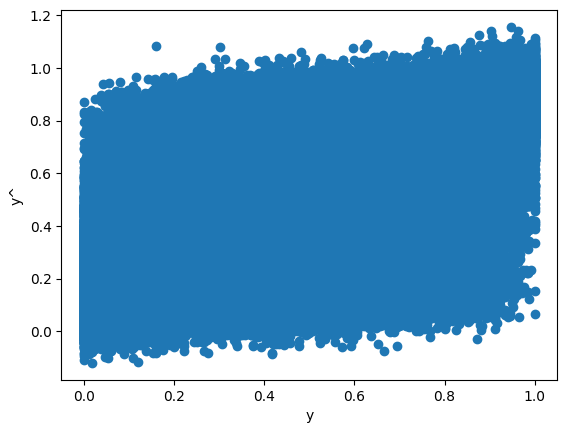


Training time: 0.019 s
----- EVALUATION ON VAL SET ------
MSE: 0.009657643190766745
RMSE 0.09827330863854511
MAE: 0.06641733357643148
R^2:  0.8522444720424238



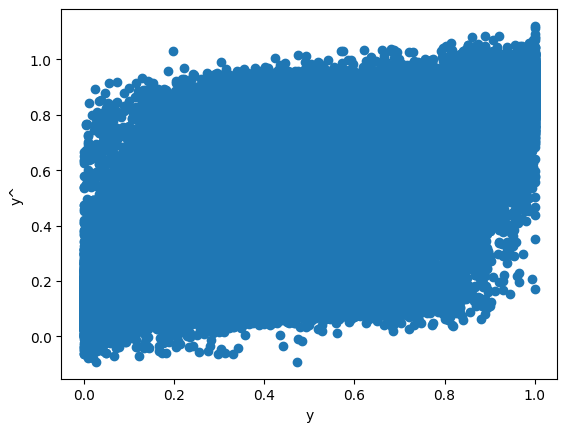


Testing time: 0.012 s
----- EVALUATION ON VAL SET ------
MSE: 0.0138884091375572
RMSE 0.11784909476766124
MAE: 0.08014580478388536
R^2:  0.8101138607888135



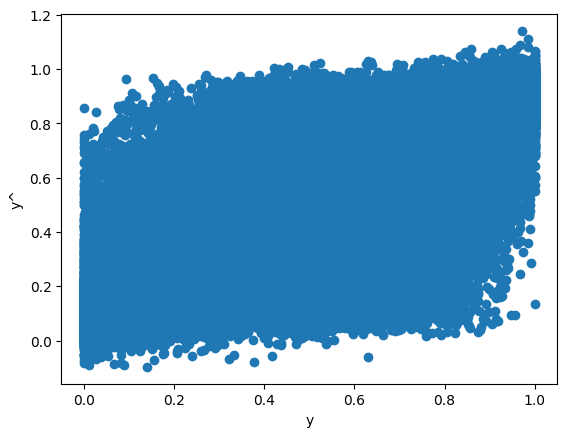

CPU times: user 24.5 s, sys: 1min 2s, total: 1min 27s
Wall time: 17.1 s


{'train': mse_t     0.013137
 rmse_t    0.114618
 mae_t     0.076638
 r2_t      0.807837
 dtype: object,
 'test': mse_t     0.009658
 rmse_t    0.098273
 mae_t     0.066417
 r2_t      0.852244
 mse_v     0.013888
 rmse_v    0.117849
 mae_v     0.080146
 r2_v      0.810114
 dtype: object}

In [31]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.013319
#  rmse_t    0.115408
#  mae_t     0.076947
#  r2_t      0.805179
#  dtype: object,
#  'test': mse_t     0.009486
#  rmse_t    0.097396
#  mae_t      0.06385
#  r2_t      0.854869
#  mse_v     0.014026
#  rmse_v    0.118431
#  mae_v     0.079915
#  r2_v      0.808233
#  dtype: object}

## Testing each month

In [32]:
%%time 

result = do_test_per_month(
    LinearRegression, dict(n_jobs=5),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 28.9 s, sys: 1min 14s, total: 1min 43s
Wall time: 11.4 s


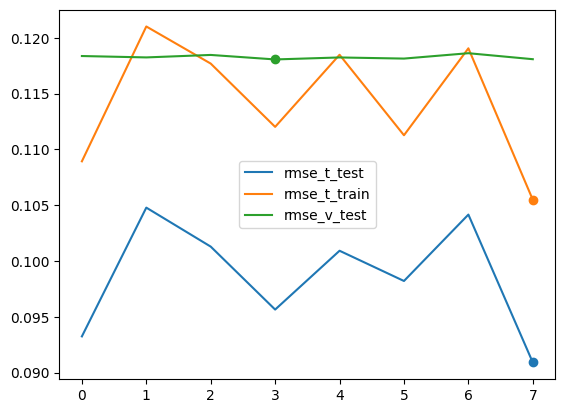

In [33]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [34]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.090114
# rmse_t_train    0.106278
# rmse_v_test     0.118463
# dtype: object

rmse_t_test     0.090908
rmse_t_train    0.105483
rmse_v_test     0.118051
dtype: object

In [35]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.870583
# r2_t_train    0.829468
# r2_v_test     0.808132
# dtype: object

r2_t_test      0.86829
r2_t_train    0.832012
r2_v_test     0.809461
dtype: object

## Testing combination of three consecutive months

In [36]:
%%time 

result = do_test_per_month_combos(
    LinearRegression, dict(n_jobs=5),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 1min 8s, sys: 3min 6s, total: 4min 15s
Wall time: 24.6 s


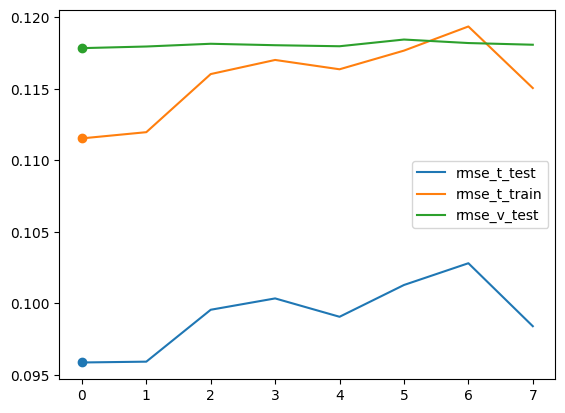

In [37]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [38]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.095179
# rmse_t_train    0.112222
# rmse_v_test     0.118457
# dtype: object

rmse_t_test     0.095866
rmse_t_train    0.111541
rmse_v_test     0.117853
dtype: object

In [39]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.858316
# r2_t_train    0.812946
# r2_v_test     0.808149
# dtype: object

r2_t_test     0.856265
r2_t_train    0.815208
r2_v_test     0.810101
dtype: object

## KNN3
### Not ideal to store and sort large data.
https://www.kaggle.com/general/352216

## SVM 
### SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. 
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python#advantages

# Decision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
%%time 

# define model 
tree_reg = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=11, 
    random_state=config.seed
)


CPU times: user 7 µs, sys: 14 µs, total: 21 µs
Wall time: 22.6 µs


## Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.9min finished



  model test
Scores: [-0.11215872 -0.1119933  -0.11177366 -0.11244083 -0.11175997]
Mean: -0.11202529697482977
Standard deviation: 0.0002550341442179634

Training time: 0.251 s
----- EVALUATION ON VAL SET ------
MSE: 0.01219622142347122
RMSE 0.11043650403499389
MAE: 0.07317588924939857
R^2:  0.8216011970808532



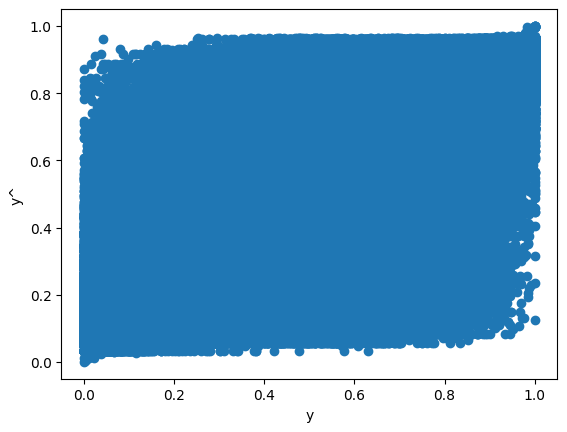


Training time: 0.06 s
----- EVALUATION ON VAL SET ------
MSE: 0.008840291950534379
RMSE 0.09402282675251994
MAE: 0.05995331142512407
R^2:  0.8647494032810075



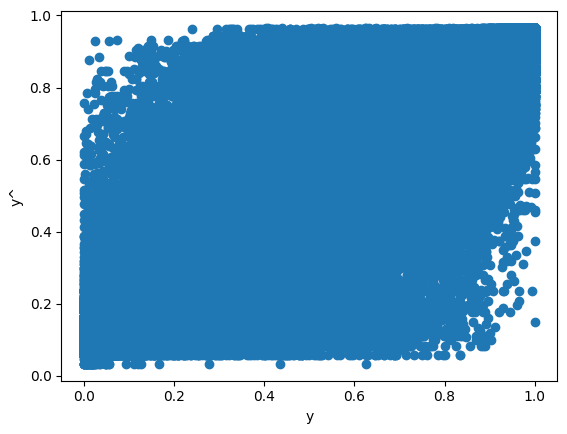


Testing time: 0.038 s
----- EVALUATION ON VAL SET ------
MSE: 0.013142268988631151
RMSE 0.11463973564445773
MAE: 0.07695077792925135
R^2:  0.8203152935653646



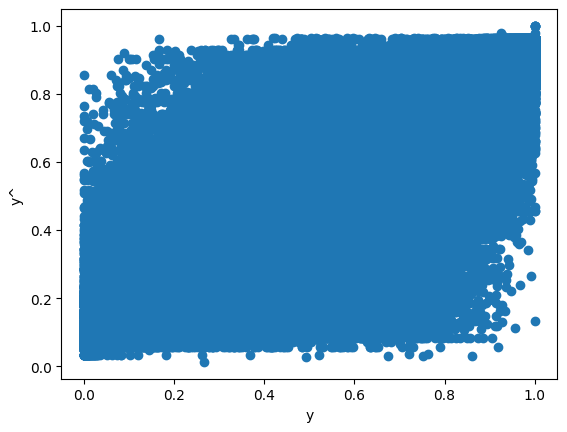

CPU times: user 2min 13s, sys: 637 ms, total: 2min 13s
Wall time: 4min 9s


{'train': mse_t     0.012196
 rmse_t    0.110437
 mae_t     0.073176
 r2_t      0.821601
 dtype: object,
 'test': mse_t      0.00884
 rmse_t    0.094023
 mae_t     0.059953
 r2_t      0.864749
 mse_v     0.013142
 rmse_v     0.11464
 mae_v     0.076951
 r2_v      0.820315
 dtype: object}

In [42]:
%%time 

test_model_train_val_test(
    tree_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.012237
#  rmse_t    0.110621
#  mae_t     0.073122
#  r2_t      0.821003
#  dtype: object,
#  'test': mse_t     0.008864
#  rmse_t    0.094151
#  mae_t     0.059995
#  r2_t       0.86438
#  mse_v     0.013122
#  rmse_v     0.11455
#  mae_v      0.07691
#  r2_v      0.820596
#  dtype: object}

## Testing each month

In [43]:
%%time 

result = do_test_per_month(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


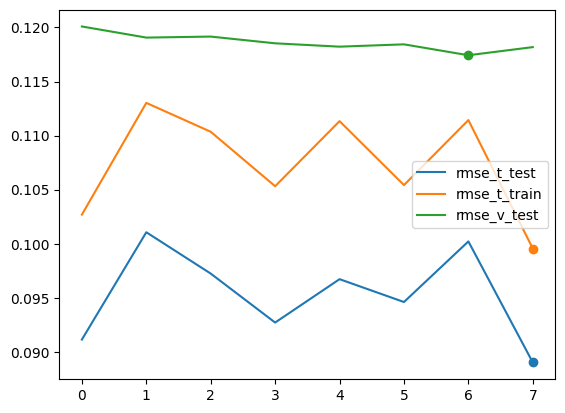

In [44]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [45]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.091301
# rmse_t_train     0.09943
# rmse_v_test     0.119586
# dtype: object

rmse_t_test     0.089012
rmse_t_train     0.09955
rmse_v_test     0.117429
dtype: object

In [46]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.867151
# r2_t_train    0.850738
# r2_v_test     0.804474
# dtype: object

r2_t_test     0.873729
r2_t_train    0.850377
r2_v_test     0.811464
dtype: object

## Testing combination of three consecutive months

In [47]:
%%time 

result = do_test_per_month_combos(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time= 1.9min
CPU times: user 4min 46s, sys: 314 ms, total: 4min 46s
Wall time: 4min 46s


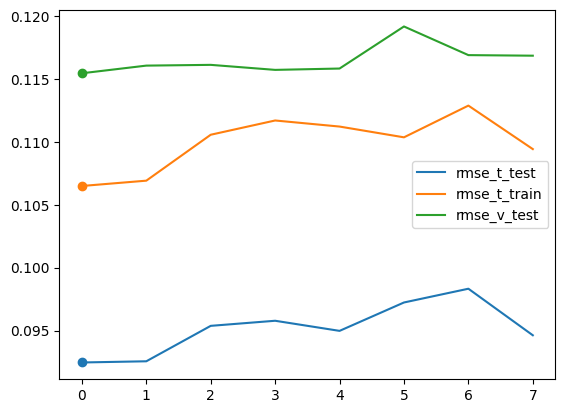

In [48]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [49]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.093224
# rmse_t_train    0.106735
# rmse_v_test     0.115668
# dtype: object

rmse_t_test     0.092469
rmse_t_train    0.106487
rmse_v_test     0.115439
dtype: object

In [50]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.864013
# r2_t_train     0.83079
# r2_v_test     0.817077
# dtype: object

r2_t_test     0.866271
r2_t_train    0.831575
r2_v_test       0.8178
dtype: object

## Fine tuning parameters

In [51]:
# define model 
tree_reg = DecisionTreeRegressor(random_state=config.seed)

param_grid = [
    {
        'max_depth':[9,11,13],
        'criterion':['friedman_mse']
    }
]

grid_search = GridSearchCV(
    tree_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [52]:
grid_search.fit(X_train_prepared, y_train_prepared)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................criterion=friedman_mse, max_depth=7; total time=  15.2s
[CV] END ................criterion=friedman_mse, max_depth=7; total time=  15.2s
[CV] END ................criterion=friedman_mse, max_depth=7; total time=  14.9s
[CV] END ................criterion=friedman_mse, max_depth=7; total time=  14.9s
[CV] END ................criterion=friedman_mse, max_depth=7; total time=  14.9s
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  18.3s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=  24.1s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=  24.2s
[CV] END .................................................... total time=   4.2s
[CV] END ........................................

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'criterion': ['friedman_mse'],
                          'max_depth': [7, 9, 11, 13, 15]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [53]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'criterion': 'friedman_mse', 'max_depth': 11}


In [54]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


DecisionTreeRegressor(criterion='friedman_mse', max_depth=11, random_state=42)

In [55]:
print("Best Score")
-grid_search.best_score_

Best Score


0.11196101731196009

In [56]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.11369669345311342 {'criterion': 'friedman_mse', 'max_depth': 7}
0.11231182208504567 {'criterion': 'friedman_mse', 'max_depth': 9}
0.11196101731196009 {'criterion': 'friedman_mse', 'max_depth': 11}
0.11316774445890336 {'criterion': 'friedman_mse', 'max_depth': 13}
0.11656498018566135 {'criterion': 'friedman_mse', 'max_depth': 15}


In [57]:
results = grid_search.cv_results_

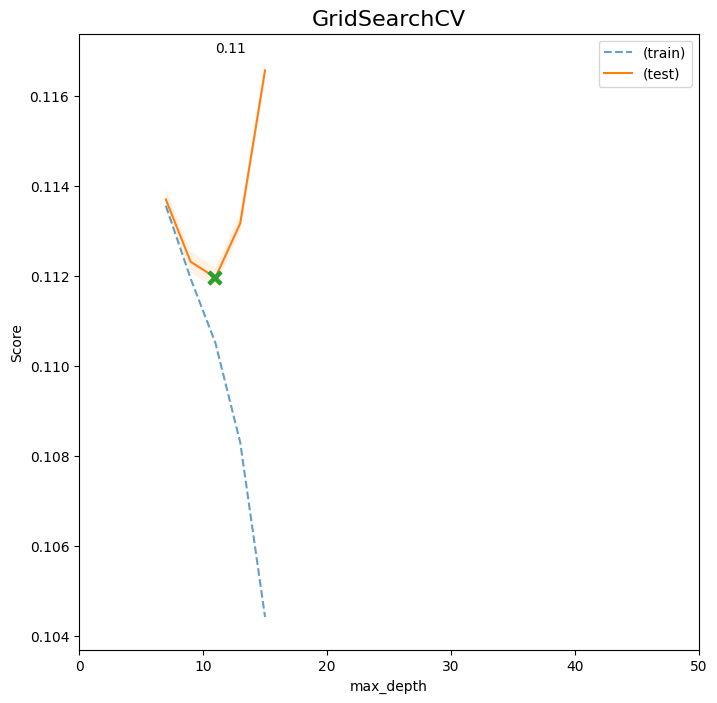

In [58]:

#plot the results
plt.figure(figsize=(8, 8))
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 50)


# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)


for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = (-results['mean_%s_score' % (sample)])
    sample_score_std = (results['std_%s_score' % (sample)])
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0)
    ax.plot(X_axis, sample_score_mean, style,
            alpha=1 if sample == 'test' else 0.7,
            label="(%s)" % ( sample))

best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
best_score =  (-results['mean_test_score' ][best_index])

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
        linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
%%time 

# define used regressor
forest=RandomForestRegressor(n_estimators=100,
                             max_depth=11,
                             criterion='friedman_mse',
                             n_jobs=10,
                             random_state=config.seed
                            )

CPU times: user 42 µs, sys: 20 µs, total: 62 µs
Wall time: 65.8 µs


## Train and test, validate model

In [ ]:
%%time

test_model_train_val_test(
    forest, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


## Testing each month

In [ ]:
%%time 

result = do_test_per_month(
    RandomForestRegressor, dict(n_estimators=100, max_depth=11, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

## Testing combination of three consecutive months

In [ ]:
%%time 

result = do_test_per_month_combos(
    RandomForestRegressor, dict(n_estimators=100, max_depth=11, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# Gaussian Process

## Gradiend Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
%%time 

boosting = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=11, 
    loss='squared_error',
    criterion='friedman_mse',
    random_state=config.seed,
    verbose=2,
    warm_start=True
)


## Train and test, validate model

In [ ]:
%%time 

test_model_train_val_test(
    boosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

## Testing each month

In [ ]:
%%time 

result = do_test_per_month(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=0
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

# CPU times: user 38min 55s, sys: 196 ms, total: 38min 55s
# Wall time: 38min 54s

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

## Testing combination of three consecutive months

In [ ]:
%%time 

result = do_test_per_month_combos(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=2
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# HistGradientBoostingRegressor

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
%%time 

hist_boosting = HistGradientBoostingRegressor(
    max_iter=100,
    loss='squared_error',
    random_state=config.seed,
    verbose=2,
    validation_fraction=0.2,
    n_iter_no_change=10,
    warm_start=True,
    l2_regularization=0.001
)


In [ ]:
# Failiing due to memory

In [ ]:
%%time 

test_model_train_val_test(
    hist_boosting, 
    (X_train_prepared.toarray(), y_train_prepared),
    (X_val_prepared.toarray(), y_val_prepared),
    (X_test_prepared.toarray(),  y_test_prepared),
    show=True
)

In [ ]:
GridSearchCV

## Generate Sample

In [ ]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [ ]:
sample_data

# apply pipeline

In [ ]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

# Prediction 

In [ ]:
%%time 

model = boosting

In [ ]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 0

In [ ]:
name

In [ ]:
yhat = model.predict(X_sample_prepared)

In [ ]:
yhat.shape

In [ ]:
sample_data['percentage_docks_available'] = yhat

In [ ]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')

In [ ]:

aux = X_test[X_test.month.isin([3]) & X_test.station_id.isin(sample_data.station_id.unique())][['station_id', 'year', 'month','day','hour', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']]


In [ ]:
sample_data = sample_data.merge(aux,
                                on=['station_id','month','day','hour'],
                                how='left')

In [ ]:

sample_data[['station_id', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx0', 'ctx1_x', 'ctx1_y', 'ctx4_x', 'ctx4_y', 'ctx3_x', 'ctx3_y', 'ctx2_x', 'ctx2_y']]



In [ ]:
np.abs(sample_data['percentage_docks_available'] - sample_data['ctx0']).plot()